<a href="https://colab.research.google.com/github/raj-jaiswal/Deep-Learning/blob/main/source/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://media.geeksforgeeks.org/wp-content/uploads/20240522174620/data-2.csv
!cat data-2.csv > data.csv && rm data-2.csv
import numpy as np
import pandas as pd

--2025-05-22 10:41:20--  https://media.geeksforgeeks.org/wp-content/uploads/20240522174620/data-2.csv
Resolving media.geeksforgeeks.org (media.geeksforgeeks.org)... 3.165.160.51, 3.165.160.9, 3.165.160.32, ...
Connecting to media.geeksforgeeks.org (media.geeksforgeeks.org)|3.165.160.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125204 (122K) [text/csv]
Saving to: ‘data-2.csv’

data-2.csv          100%[===================>] 122.27K  --.-KB/s    in 0.02s   

2025-05-22 10:41:20 (6.41 MB/s) - ‘data-2.csv’ saved [125204/125204]



In [2]:
data = pd.read_csv('data.csv').iloc[:, 1:-1]
target = data.iloc[:, 0].map({'M': 0, 'B': 1}) # Malignant: 0, Benign: 1
data = data.iloc[:, 1:]
data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
target = target.values
data = data.values

In [201]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def ReLU(x):
    return np.maximum(0, x)

def ReLU_derivative(x):
    return np.where(x > 0, 1, 0)

class NeuralNetwork:
    def __init__(self, L, lr, activation=None, nNodes=3, derivative=None):
        self.layers = L  # Number of hidden layers
        self.activation = activation if activation else self.sigmoid
        if activation and not derivative:
            raise Exception('Provide derivative for given activation function.')
        self.derivative = derivative if derivative else self.sigmoid_derivative
        self.nNodes = nNodes
        self.lr = lr
        self.weights = []
        self.biases = []
        self.scores=[]

    def sigmoid(self, x):
        x = np.clip(x, -20, 20)
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def train(self, data, y, plot=False, nIter=1000):
        if self.weights:
            raise Exception('Model Already Trained.')

        self.initialise_weights(data)
        X = np.array(data).T
        Y = np.array(y).reshape(1, -1)
        m = X.shape[1]  # Number of examples

        for i in range(nIter):
            # Forward pass
            A = [X]  # List to store activations
            Z = []    # List to store pre-activations

            # Hidden layers
            for j in range(self.layers):
                Zj = self.weights[j].dot(A[-1]) + self.biases[j]
                Aj = self.activation(Zj)
                Z.append(Zj)
                A.append(Aj)

            # Output layer
            Z_out = self.weights[-1].dot(A[-1]) + self.biases[-1]
            A_out = self.sigmoid(Z_out)
            Z.append(Z_out)
            A.append(A_out)

            # Backward pass
            dZ = A_out - Y
            dW = dZ.dot(A[-2].T) / m
            db = np.sum(dZ, axis=1, keepdims=True) / m
            self.weights[-1] -= self.lr * dW
            self.biases[-1] -= self.lr * db

            # Backprop through hidden layers
            for j in reversed(range(self.layers)):
                dZ = self.weights[j+1].T.dot(dZ) * self.derivative(Z[j])
                dW = dZ.dot(A[j].T) / m
                db = np.sum(dZ, axis=1, keepdims=True) / m
                self.weights[j] -= self.lr * dW
                self.biases[j] -= self.lr * db

            if i % 100 == 0:
                self.scores.append(self.score(data, y))
                print(f"Iteration {i}: Score {self.scores[-1]}")
        if plot:
            self.plot_scores()

    def plot_scores(self):
        plt.plot(self.scores)
        plt.xlabel('Iterations')
        plt.ylabel('Score')
        plt.title('Score vs Iteration')
        plt.show()

    def initialise_weights(self, X):
        # Input to first hidden layer
        self.weights.append(np.random.randn(self.nNodes, X.shape[1]) * 0.01)
        self.biases.append(np.zeros((self.nNodes, 1)))

        # Hidden layers
        for _ in range(self.layers - 1):
            self.weights.append(np.random.randn(self.nNodes, self.nNodes) * 0.01)
            self.biases.append(np.zeros((self.nNodes, 1)))

        # Output layer
        self.weights.append(np.random.randn(1, self.nNodes) * 0.01)
        self.biases.append(np.zeros((1, 1)))

    def predict(self, data):
        X = np.array(data).T
        if not self.weights:
            raise Exception('Train Model Before Predicting.')

        # Forward pass
        for j in range(self.layers):
            X = self.activation(self.weights[j].dot(X) + self.biases[j])
        X = self.sigmoid(self.weights[-1].dot(X) + self.biases[-1])
        return np.round(X)

    def score(self, X, y):
        predicted = self.predict(X)
        return np.mean(predicted == y)

Iteration 0: Score 0.6274165202108963
Iteration 100: Score 0.6274165202108963
Iteration 200: Score 0.6274165202108963
Iteration 300: Score 0.6274165202108963
Iteration 400: Score 0.6274165202108963
Iteration 500: Score 0.6274165202108963
Iteration 600: Score 0.6274165202108963
Iteration 700: Score 0.6274165202108963
Iteration 800: Score 0.6274165202108963
Iteration 900: Score 0.6274165202108963
Iteration 1000: Score 0.6274165202108963
Iteration 1100: Score 0.6274165202108963
Iteration 1200: Score 0.9578207381370826
Iteration 1300: Score 0.984182776801406
Iteration 1400: Score 0.984182776801406
Iteration 1500: Score 0.984182776801406
Iteration 1600: Score 0.9859402460456942
Iteration 1700: Score 0.9859402460456942
Iteration 1800: Score 0.9859402460456942
Iteration 1900: Score 0.9876977152899824
Iteration 2000: Score 0.9876977152899824
Iteration 2100: Score 0.9876977152899824
Iteration 2200: Score 0.9912126537785588
Iteration 2300: Score 0.9894551845342706
Iteration 2400: Score 0.9929701

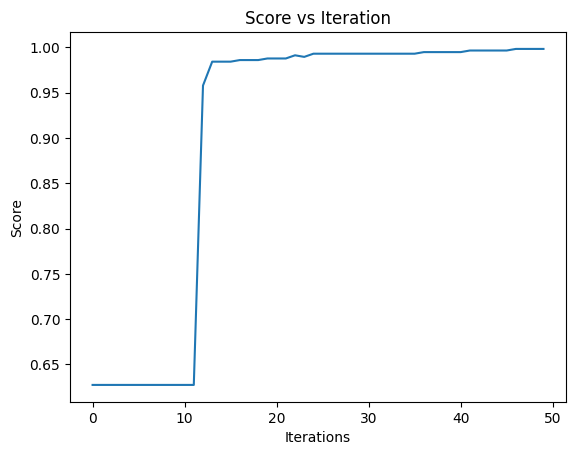

final score: 0.9982425307557118


In [204]:
nn = NeuralNetwork(2, 0.1, activation=ReLU, derivative=ReLU_derivative, nNodes=4)
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
nn.train(data, target, nIter=5000, plot=True)
print('final score:', nn.score(data, target))